# Autoencoder for the Kolmogorov Flow

In this session, you will need to use what you learned in the previous notebooks to develop a particular neural network called an autoencoder.
The Kolmogorov flow is governed by the following equation:
\begin{align}
    \nabla \cdot \mathbf{u} &= 0\\
   \partial_t \mathbf{u} + \mathbf{u} \cdot \nabla \mathbf{u} &= -\nabla p + \frac{1}{Re} \Delta \mathbf{u} + \mathbf{f}
\end{align}
where $\mathbf{u} = (u,v)$ is the flow velocity over the domain $(x,y)\in \Omega = [0,2\pi]\times[0,2\pi]$ with periodic boundary conditions and $p$ is the pressure field.
In the Kolmogorov flow, the forcing term, $\mathbf{f}$ is $\mathbf{f} = (sin(k_fy),0)$.

The Kolmogorov flow admits a laminar solution $u= \frac{Re}{k_f^2} \sin(k_fy)$, $v=0$ which is unstable for large enough $Re$ and $k_f$.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 1. Import librairies

In [ ]:
import numpy as np
import tensorflow as tf
# from datetime import datetime
import matplotlib.pyplot as plt
import h5py
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPool2D, UpSampling2D, concatenate, BatchNormalization, Conv2DTranspose, Flatten, Reshape




# 2. Read dataset

In [ ]:
hf = h5py.File('ML_WORKSHOP_Kolmogorov_Re20_T1000_DT01.h5','r')
Nx = 24
Nu = 1
t = np.array(hf.get('t'))
u_all = np.zeros((Nx,Nx,len(t),Nu))
u_all[:,:,:,0] = np.array(hf.get('u_refined'))
# u_all[:,:,:,1] = np.array(hf.get('v_refined'))
u_all = np.transpose(u_all,[2,0,1,3])
hf.close()
print(u_all.shape)

# normalize data
u_min = np.amin(u_all[:,:,:,0])
u_max = np.amax(u_all[:,:,:,0])
u_all[:,:,:,0] = (u_all[:,:,:,0] - u_min) / (u_max - u_min)
if Nu==2:
    v_min = np.amin(u_all[:,:,:,1])
    v_max = np.amax(u_all[:,:,:,1])
    u_all[:,:,:,1] = (u_all[:,:,:,1] - v_min) / (v_max - v_min)


(1000, 24, 24, 1)


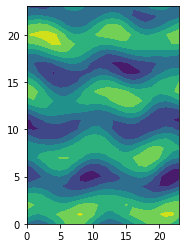

In [ ]:
# visualization of the dataset
%matplotlib inline
fig = plt.figure()
ax = fig.add_subplot(121)
ax.contourf(u_all[50,:,:,0])
# ax2 = fig.add_subplot(122)
# ax2.contourf(u_all[0,:,:,1])

# 3. Prepare dataset

In [ ]:
val_ratio = int(np.round(0.75*len(u_all)))
test_ratio = int(np.round(0.95*len(u_all)))

u_train = u_all[:val_ratio,:,:,:].astype('float32')
u_val = u_all[val_ratio:test_ratio,:,:,:].astype('float32')
u_test = u_all[test_ratio:,:,:,:].astype('float32')
#del u_all


# 4. Define the network

In [ ]:
input_img = Input(shape=(Nx,Nx,Nu))

nb_layer = 0

x = Conv2D(8,(3,3), padding='same', activation='relu')(input_img)
x = MaxPool2D((2,2), padding='same')(x)
x = Conv2D(16,(3,3), padding='same', activation='relu')(x)
x = MaxPool2D((2,2), padding='same')(x)
x = Conv2D(32,(3,3), padding='same', activation='relu')(x)
x = MaxPool2D((2,2), padding='same')(x)
x = Conv2D(64,(3,3), padding='same', activation='relu')(x)
encoded = MaxPool2D((3,3), padding='same')(x)

x = Conv2DTranspose(64,(3,3), padding='same', activation='relu')(encoded)
x = UpSampling2D((3,3))(x)
x = Conv2DTranspose(32,(3,3), padding='same', activation='relu')(x)
x = UpSampling2D((2,2))(x)
x = Conv2DTranspose(16,(3,3), padding='same', activation='relu')(x)
x = UpSampling2D((2,2))(x)
x = Conv2DTranspose(8,(3,3), padding='same', activation='relu')(x)
x = UpSampling2D((2,2))(x)
decoded = Conv2DTranspose(Nu,(3,3), activation='linear', padding='same')(x)

autoencoder = tf.keras.models.Model(input_img,decoded)
encoder = tf.keras.models.Model(input_img,encoded)

# definition of the decoder
encoded_input = Input(shape=(1,1,encoded.shape[3]))
deco = autoencoder.layers[-7](encoded_input) # we re-use the same layers as the ones of the autoencoder
for i in range(6):
    deco = autoencoder.layers[-6+i](deco)

decoder = tf.keras.models.Model(encoded_input,deco)

encoder.summary()
decoder.summary()
autoencoder.summary()

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 24, 24, 1)]       0         
                                                                 
 conv2d_8 (Conv2D)           (None, 24, 24, 8)         80        
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 12, 12, 8)        0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 12, 12, 16)        1168      
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 6, 6, 16)         0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 6, 6, 32)          4640

# 5. Training the Network
We use the difference between the network output and the real image to calculate or cost/loss function. As an optimizier we choose the AdamOptimizer and tell it which function value to minimize

In [ ]:
autoencoder.compile(optimizer='adam',loss='mse')

In [ ]:
checkpoint_filepath = './checkpoint'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True)
early_stop_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)

In [ ]:
nb_epochs = 5
batch_size = 20
hist = autoencoder.fit(u_train, u_train, epochs=nb_epochs, batch_size=batch_size,
                shuffle=True,validation_data=(u_test, u_test),
                       verbose=1,
                       callbacks=[model_checkpoint_callback,early_stop_callback])

Epoch 1/5
38/38 [==============================] - 1s 22ms/step - loss: 0.0877 - val_loss: 0.0338
Epoch 2/5
38/38 [==============================] - 1s 17ms/step - loss: 0.0270 - val_loss: 0.0212
Epoch 3/5
38/38 [==============================] - 1s 18ms/step - loss: 0.0183 - val_loss: 0.0175
Epoch 4/5
38/38 [==============================] - 1s 17ms/step - loss: 0.0160 - val_loss: 0.0169
Epoch 5/5
38/38 [==============================] - 1s 17ms/step - loss: 0.0152 - val_loss: 0.0167


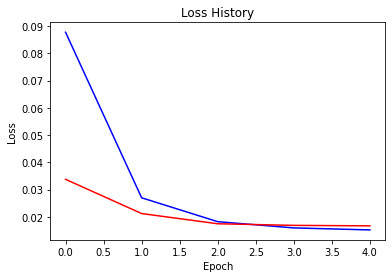

In [ ]:
loss_history = hist.history['loss']
val_history = hist.history['val_loss']
%matplotlib inline
plt.plot(loss_history,'b')
plt.plot(val_history,'r')
plt.title("Loss History")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.show()

# 6. Visualization of some prediction cases

(1, 24, 24, 1)


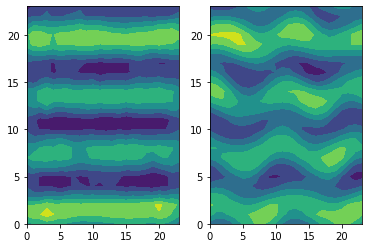

In [ ]:
y_nn = autoencoder.predict(u_test[0:1,:,:,:])
print(y_nn.shape)
%matplotlib inline
fig = plt.figure()
ax = fig.add_subplot(121)
ax.contourf(y_nn[0,:,:,0])
ax = fig.add_subplot(122)
ax.contourf(u_test[0,:,:,0])
